# Capstone Project - Sales Forecasting

### Problem Statement:
Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. Currently, the forecasting is taken care of by the store managers who are tasked with forecasting daily sales for the next six weeks. 

In [1]:
# Importing the Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from pylab import rcParams
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from sklearn.metrics import mean_squared_error

### Step 1: Reading the data file

In [2]:
train = pd.read_csv("train.csv")
store = pd.read_csv("store.csv")

In [3]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
train.shape

(1017209, 9)

In [6]:
store.shape

(1115, 10)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [8]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


**Observation:** Store dataset has some missing values. Hence, data processing is needed before performing EDA

In [9]:
# Checking null percentage
store.isnull().mean() * 100

Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.269058
CompetitionOpenSinceMonth    31.748879
CompetitionOpenSinceYear     31.748879
Promo2                        0.000000
Promo2SinceWeek              48.789238
Promo2SinceYear              48.789238
PromoInterval                48.789238
dtype: float64

**Observation:** Indication of null values in the promo variables means there were no promos in the week. Hence the missing values can be imputed with 0. For the missing values in the competition variables, it can be imputed with mean

In [10]:
# Imputing with 0 for the missing values
store["Promo2SinceWeek"].fillna(0, inplace=True)
store["Promo2SinceYear"].fillna(0, inplace=True)
store["PromoInterval"].fillna(0, inplace=True)
store["CompetitionOpenSinceMonth"].fillna(0,inplace = True)
store["CompetitionOpenSinceYear"].fillna(0,inplace = True)
store["CompetitionDistance"].fillna(0,inplace = True)

store['CompetitionDistance'].fillna(store['CompetitionDistance'].mean(), inplace=True)

## Step 2: Exploratory Data Analysis - EDA

In [11]:
# Writing a user defined function for plots
def count_plot(features,df):
    columns=4
    rows = len(features)//columns +1
    fig = plt.figure(figsize=(16, rows*5))
    dataframe = df.copy()
    for plot, feature in enumerate(features):
        fig.add_subplot(rows,columns,plot+1)
        fig.tight_layout(h_pad=5, w_pad=5)
        dataframe[feature] = dataframe[feature].fillna('Missing')
        ax = sns.countplot(x=feature, data=dataframe,order = dataframe[feature].value_counts().index)
        plt.xticks(rotation = 90)
        plt.title("for {}".format(feature))
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}'.format(height/len(dataframe) * 100),
                    ha="center")

## Univariate Data Analysis

In [12]:
# storing store df categorical variables

store_cat_vars=['StoreType','Assortment','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval']

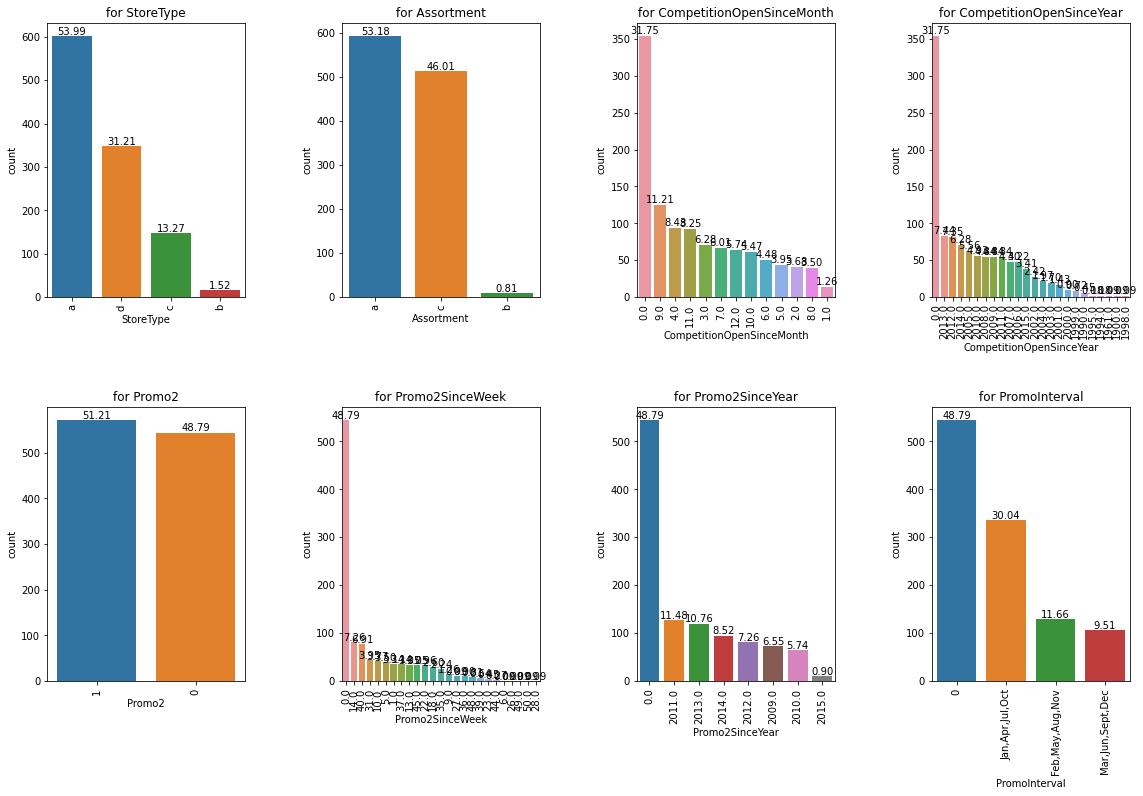

In [13]:
# Plot for store dataset
count_plot(store_cat_vars,store)

**Observation:**
- there is almost 54% stores belonging to type A and for the assortment is also the same
- 31% missing values in the competition open since month indicates either there is no value or there is no competition
- The promo2 for the stores is almost the similar result

In [14]:
# storing train df categorical variables
train_cat_vars=['DayOfWeek','Open', 'Promo', 'StateHoliday', 'SchoolHoliday']

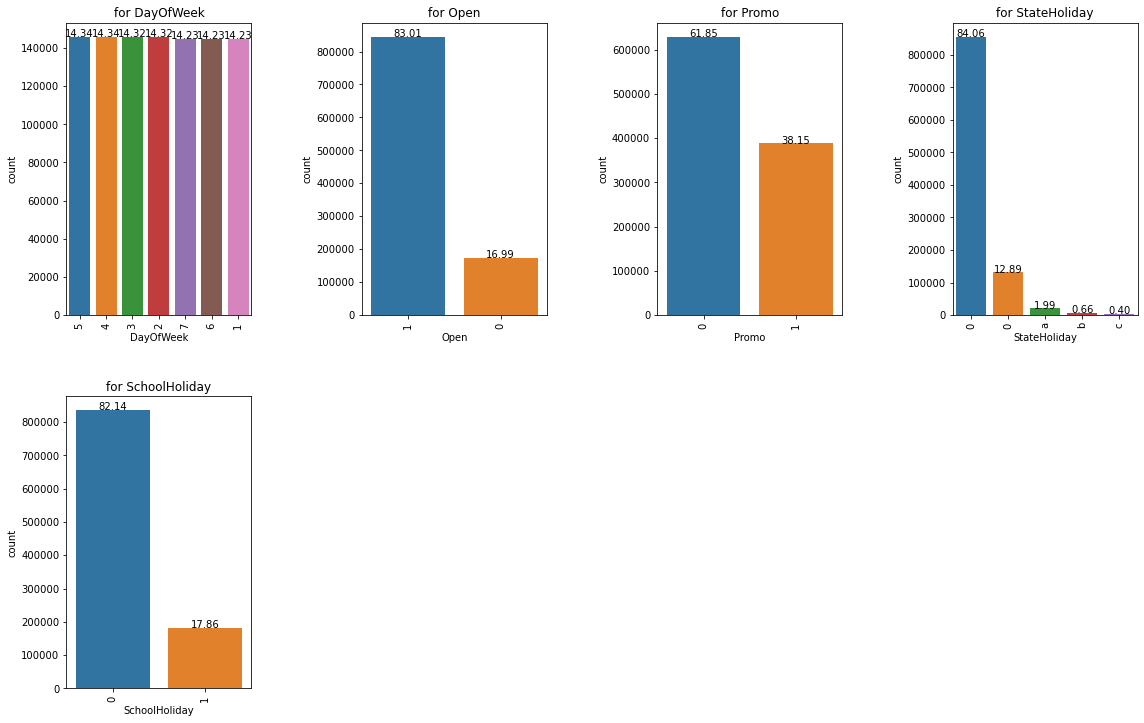

In [15]:
# Count plots for store data

count_plot(train_cat_vars,train)

**Observation:** The sales for all the days of the week is almost similar

## Box plot for Store dataset

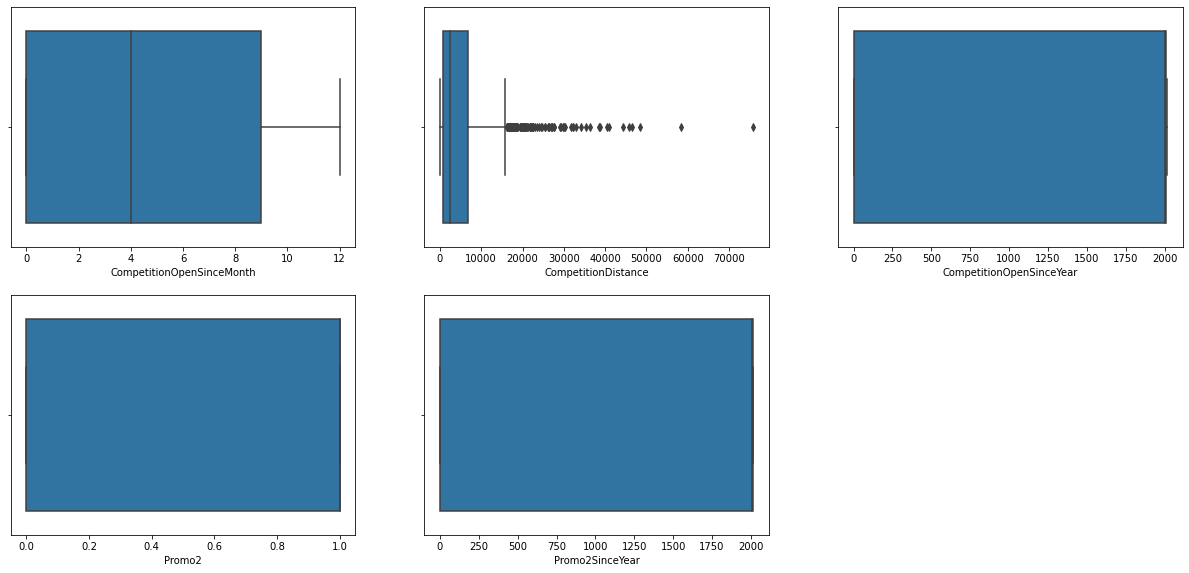

<AxesSubplot:xlabel='Promo2SinceWeek'>

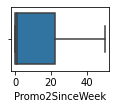

In [16]:
plt.figure(figsize=(21, 15))
plt.subplot(3,3,1)
sns.boxplot(x = 'CompetitionOpenSinceMonth', data = store)

plt.subplot(3,3,2)
sns.boxplot(x = 'CompetitionDistance', data = store)

plt.subplot(3,3,3)
sns.boxplot(x = 'CompetitionOpenSinceYear',data = store)
 
plt.subplot(3,3,4)
sns.boxplot(x = 'Promo2', data = store)

plt.subplot(3,3,5)
sns.boxplot(x = 'Promo2SinceYear', data = store)
plt.show()

plt.subplot(3,3,6)
sns.boxplot(x = 'Promo2SinceWeek', data = store)

**Observation:** Few outliers are observed in 'CompetitionDistance' and 'CompetitionOpenSinceYear'. These outliers can be removed by capping the highest values to the 99th percentile

In [17]:
# Capping the values to the 99th percentile
store.loc[store.CompetitionDistance>store.CompetitionDistance.quantile(.99),"CompetitionDistance"]=store.CompetitionDistance.quantile(.99)

## Step 3: Merging the Store and train Dataset

In [18]:
train = train.merge(right=store, on='Store', how='inner')

In [19]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [20]:
train.shape

(1017209, 18)

In [21]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.297227e+03,4.926878e+00,1.370173e+03,5.005638e-01,1.164767e+01,1.007011e+03
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.056706e+03,4.283543e+00,9.353634e+02,4.999999e-01,1.532393e+01,1.005877e+03
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.320000e+03,4.000000e+00,2.006000e+03,1.000000e+00,1.000000e+00,2.009000e+03
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.880000e+03,9.000000e+00,2.011000e+03,1.000000e+00,2.200000e+01,2.012000e+03
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,3.510780e+04,1.200000e+01,2.015000e+03,1.000000e+00,5.000000e+01,2.015000e+03


## Multivariate Analysis

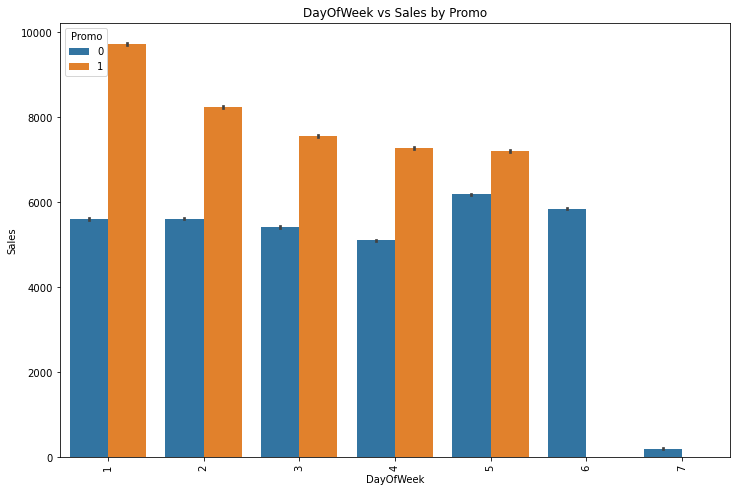

In [22]:
# Checking co-relation between Sales vs Days vs Promo

plt.figure(figsize=(12, 8))
sns.barplot(x='DayOfWeek',y='Sales',hue='Promo',data=train)
plt.xticks(rotation = 90)

plt.title("DayOfWeek vs Sales by Promo")
plt.show()

**Observation:** It is evident from the above plot that sales has high correlation with the promo

<Figure size 2520x2520 with 0 Axes>

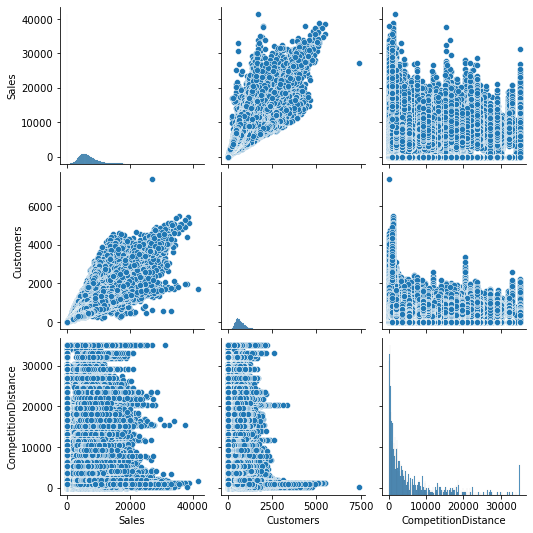

In [23]:
# Checking for Numerical variable
plt.figure(figsize=(35, 35))
sns.pairplot(train[['Sales','Customers','CompetitionDistance']])
plt.show()

**Observation:** It is apparent that the sales increasing with increasing number of customers

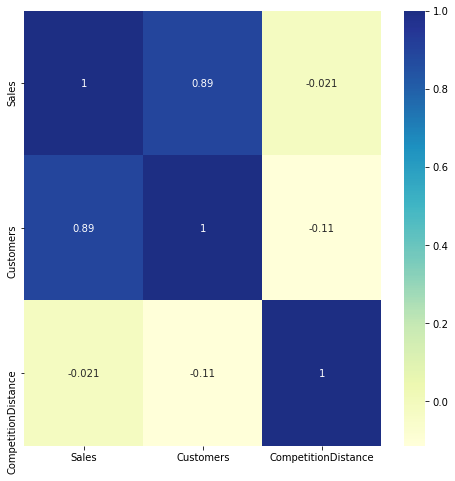

In [24]:
# Checking co-relation for numercial variables using heatmap
corr = train[['Sales','Customers','CompetitionDistance']].corr()
plt.figure(figsize = (8, 8))
sns.heatmap(corr, annot = True,center=0.5,cmap="YlGnBu")
plt.show()

**Observation:** There is high correlation between cusomters and sales

## Step 4: Data Preparation

### Creating Dummy Variables

In [25]:
# Creating dummy variable for Assortment 
dummies=pd.get_dummies(train['Assortment'],drop_first=True,prefix='Assortment')
train=pd.concat([train,dummies],axis=1)

# Creating dummy variable for "StoreType"
dummies=pd.get_dummies(train['StoreType'],drop_first=True,prefix='StoreType')
train=pd.concat([train,dummies],axis=1)

# Creating dummy variables for "DayofWeek"
dummies=pd.get_dummies(train['DayOfWeek'],drop_first=True,prefix='DayOfWeek')
train=pd.concat([train,dummies],axis=1)

In [26]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Assortment_c,StoreType_b,StoreType_c,StoreType_d,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,0,1,0,0,0,0,1,0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,0,0,1,0,0,0,1,0,0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,0,0,1,0,0,1,0,0,0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,0,0,1,0,1,0,0,0,0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,0,0,1,0,0,0,0,0,0,0


In [27]:
# Merging the 'competitionOpenSinceYear' and 'CompetitionOpenSinceMonth' to a single columns
train['CompetitionOpenSince'] = train.CompetitionOpenSinceYear.astype(int).astype(str) + '-' + train.CompetitionOpenSinceMonth.astype(int).astype(str) + '-01'
train.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1,inplace=True)
train.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,StoreType_b,StoreType_c,StoreType_d,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,CompetitionOpenSince
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,1,0,0,0,0,1,0,0,2008-9-01
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,0,1,0,0,0,1,0,0,0,2008-9-01
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,0,1,0,0,1,0,0,0,0,2008-9-01
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,0,1,0,1,0,0,0,0,0,2008-9-01
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,0,1,0,0,0,0,0,0,0,2008-9-01


In [28]:
# Imputing the NULL value columns to NULL 
train.loc[train.CompetitionOpenSince=='0-0-01','CompetitionOpenSince']=np.nan

In [29]:
#Checking datatypes

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 28 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Store                 1017209 non-null  int64  
 1   DayOfWeek             1017209 non-null  int64  
 2   Date                  1017209 non-null  object 
 3   Sales                 1017209 non-null  int64  
 4   Customers             1017209 non-null  int64  
 5   Open                  1017209 non-null  int64  
 6   Promo                 1017209 non-null  int64  
 7   StateHoliday          1017209 non-null  object 
 8   SchoolHoliday         1017209 non-null  int64  
 9   StoreType             1017209 non-null  object 
 10  Assortment            1017209 non-null  object 
 11  CompetitionDistance   1017209 non-null  float64
 12  Promo2                1017209 non-null  int64  
 13  Promo2SinceWeek       1017209 non-null  float64
 14  Promo2SinceYear       1017209 non-

In [30]:
# Converting the Date and CompetitionOpenSince to datetime objects
train['Date']=pd.to_datetime(train['Date'],errors='coerce')
train['CompetitionOpenSince']=pd.to_datetime(train['CompetitionOpenSince'],errors='coerce')

In [31]:
def competition(rec):
    if rec["CompetitionOpenSince"]>rec["Date"]:
        return 1
    else:
        return 0
train['Before_Competition']=train[['CompetitionOpenSince','Date']].apply(competition,axis=1)

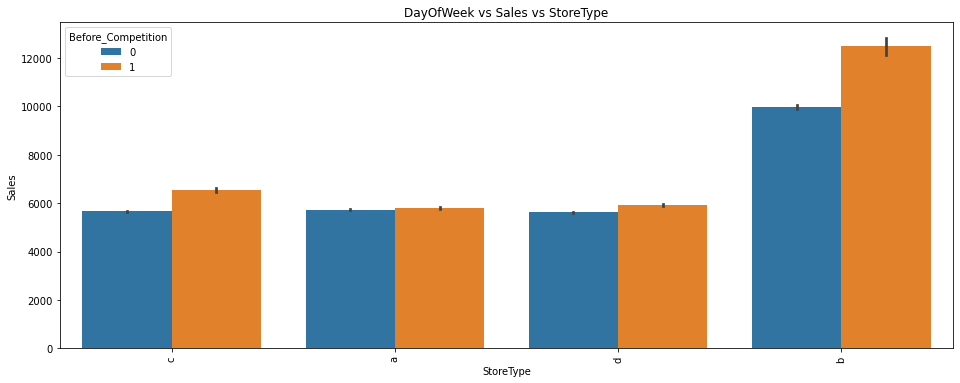

In [32]:
plt.figure(figsize=(16, 6))
sns.barplot(x='StoreType',y='Sales',hue='Before_Competition',data=train)
plt.title("DayOfWeek vs Sales vs StoreType")
plt.xticks(rotation = 90)
plt.show()

**Observation:** Since the sales of the stores before and after the competition is almost the same, the variables "Before_Competition" and "CompetitionOpenSince" can be dropped

In [33]:
train.drop(['Before_Competition',"CompetitionOpenSince"],inplace=True,axis=1)

In [34]:
# Dropping the variables that are not providing any value to the analysis
train.drop(['Promo2','Promo2SinceWeek','Promo2SinceYear','Promo2SinceYear',"Assortment","StoreType","DayOfWeek"],inplace=True,axis=1)

In [35]:
#Setting date as index
train_df=train.set_index('Date')

In [36]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 20 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Store                1017209 non-null  int64  
 1   Sales                1017209 non-null  int64  
 2   Customers            1017209 non-null  int64  
 3   Open                 1017209 non-null  int64  
 4   Promo                1017209 non-null  int64  
 5   StateHoliday         1017209 non-null  object 
 6   SchoolHoliday        1017209 non-null  int64  
 7   CompetitionDistance  1017209 non-null  float64
 8   PromoInterval        1017209 non-null  object 
 9   Assortment_b         1017209 non-null  uint8  
 10  Assortment_c         1017209 non-null  uint8  
 11  StoreType_b          1017209 non-null  uint8  
 12  StoreType_c          1017209 non-null  uint8  
 13  StoreType_d          1017209 non-null  uint8  
 14  DayOfWeek_2          1017209 non-nu

In [37]:
train_df.head(3)

,Store,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,PromoInterval,Assortment_b,Assortment_c,StoreType_b,StoreType_c,StoreType_d,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5263,555,1,1,0,1,1270.0,0,0,0,0,1,0,0,0,0,1,0,0
2015-07-30,1,5020,546,1,1,0,1,1270.0,0,0,0,0,1,0,0,0,1,0,0,0
2015-07-29,1,4782,523,1,1,0,1,1270.0,0,0,0,0,1,0,0,1,0,0,0,0


## Step 5: Time Series Analysis

Considering "Customers" as the exogenous (dependent) variable since, 'sales' is linearly related to the 'customers' variable

In [38]:
# Grouping the variables by date
train_date_group = train_df.groupby('Date').agg({'Sales': 'mean',
                                           'Customers':'mean', 
                                           'Promo': 'sum',
                                           'SchoolHoliday':'sum',
                                           'DayOfWeek_2':'mean',
                                           'DayOfWeek_3':'mean',
                                           'DayOfWeek_4':'mean',
                                           'DayOfWeek_5':'mean',
                                           'DayOfWeek_6':'mean',
                                           'DayOfWeek_7':'mean'})
train_date_group.head()

,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,
2013-01-01,87.284560,17.496409,0,1114,1,0,0,0,0,0
2013-01-02,6233.030493,748.049327,0,1115,0,1,0,0,0,0
2013-01-03,5693.112108,682.547085,0,1040,0,0,1,0,0,0
2013-01-04,5954.218834,701.468161,0,1040,0,0,0,1,0,0
2013-01-05,5337.751570,616.566816,0,112,0,0,0,0,1,0


In [39]:
# Creating a user defined function for the time series plots
def TimeSeries_plot(series,c):
    fig = plt.figure(figsize=(20, 3))
    series.plot()
    plt.xlabel('Date')
    plt.ylabel(c)
    plt.title('For {}'.format(c))
    plt.show()
    
def Seasonal_Decomposition(series,c,model):
    rcParams['figure.figsize'] = 18, 14
    decomposition = sm.tsa.seasonal_decompose(series, model=model) # additive seasonal index
    fig = decomposition.plot()
    plt.show()
    print('Mean Residual for {}={}'.format(c,decomposition.resid.mean()))


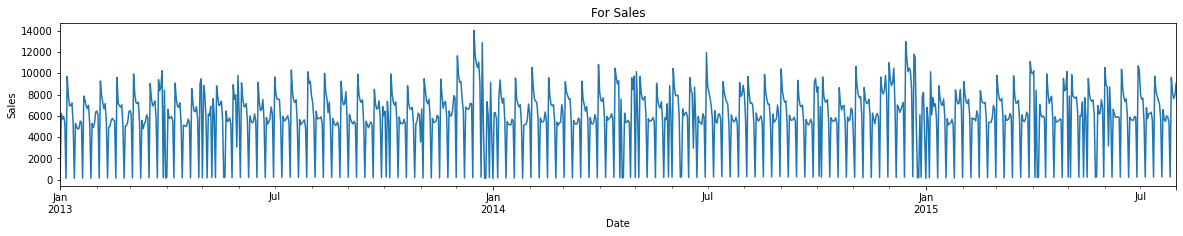

In [40]:
# Plotting time series chart for Sales
TimeSeries_plot(train_date_group['Sales'],'Sales')

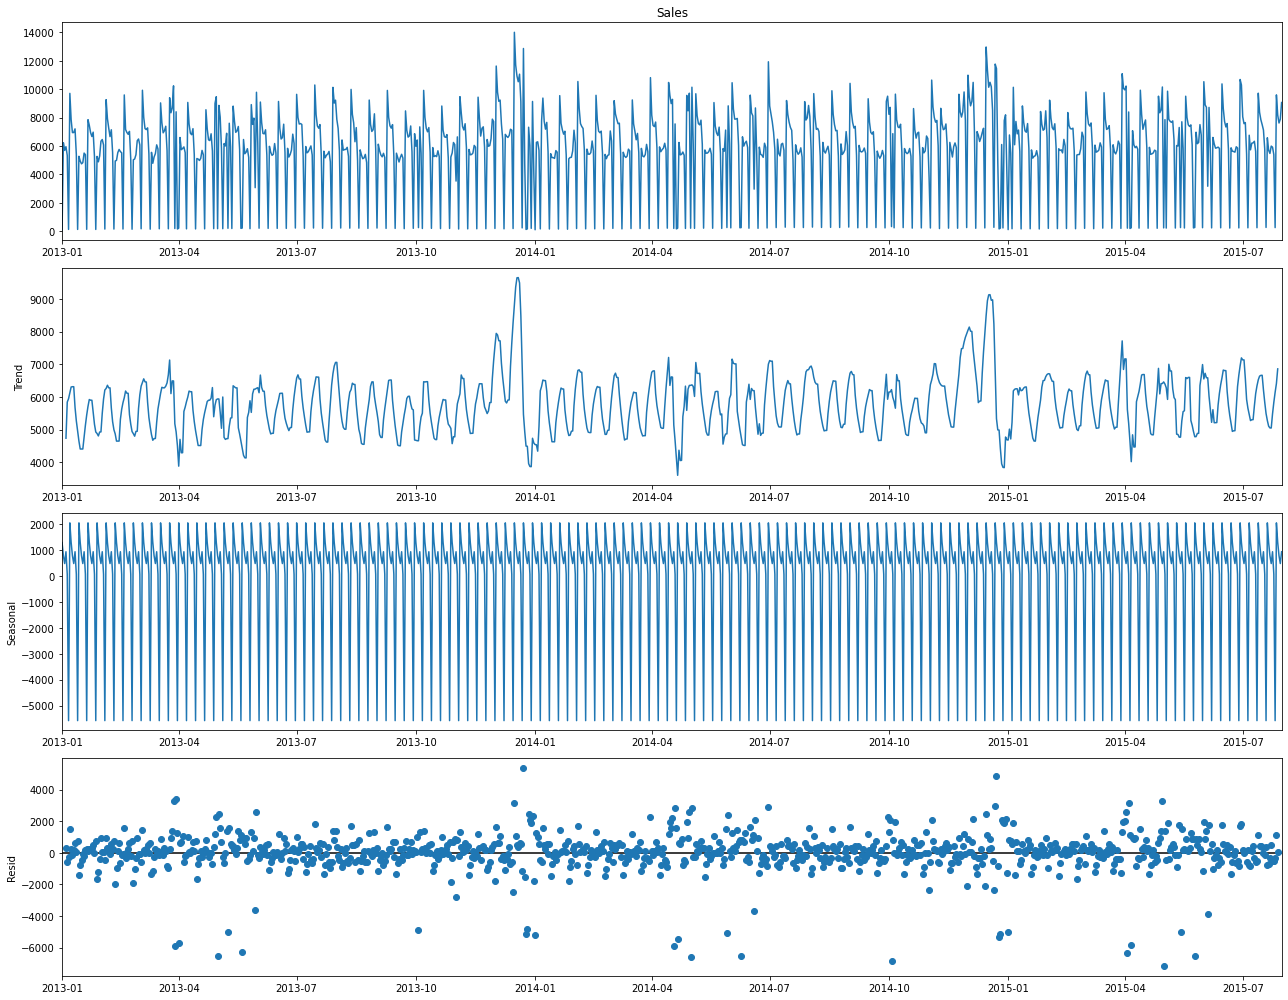

Mean Residual for Sales=0.6202792140320815


In [41]:
Seasonal_Decomposition(train_date_group['Sales'],'Sales','additive')

## Casuality testing

In [42]:
# Casuality test for customers vs sales

# importing library
from statsmodels.tsa.stattools import grangercausalitytests


causality_sales=grangercausalitytests(train_date_group[['Sales','Customers']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=207.3179, p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=207.9810, p=0.0000  , df=1
likelihood ratio test: chi2=187.9060, p=0.0000  , df=1
parameter F test:         F=207.3179, p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=117.7859, p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=236.8316, p=0.0000  , df=2
likelihood ratio test: chi2=211.2191, p=0.0000  , df=2
parameter F test:         F=117.7859, p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=84.6075 , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=255.7290, p=0.0000  , df=3
likelihood ratio test: chi2=226.1668, p=0.0000  , df=3
parameter F test:         F=84.6075 , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=70.9777 , p=0.0000  

## Stationary Test

In [43]:
# Testing using ADF statistic

from statsmodels.tsa.stattools import adfuller

def Stationary_Test(df):
    for i in df.columns:
        print('For ',i)
        print('*'*100)
        r=adfuller(df[i],autolag='AIC')
        print('ADF_Statistic=',r[0])
        print('P_value=',r[1])
        output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
        p_value = output['pvalue']
        if p_value <= 0.05:
            print(f" => P_Value = {p_value}. Rejecting Null Hypothesis")
            print(f" => Series is Stationary")
        else:
            print(f" => P_Value = {p_value}. Weak evidence to reject the Null Hypothesis")
            print(f" => Series is Non-Stationary")  

In [44]:
Stationary_Test(train_date_group[['Sales','Customers']])

For  Sales
****************************************************************************************************
ADF_Statistic= -5.650822837207902
P_value= 9.870006549261686e-07
 => P_Value = 0.0. Rejecting Null Hypothesis
 => Series is Stationary
For  Customers
****************************************************************************************************
ADF_Statistic= -5.933710149589014
P_value= 2.3477735379188819e-07
 => P_Value = 0.0. Rejecting Null Hypothesis
 => Series is Stationary


**Observation:** The p value for both the variables is less than 0.05 stating that the series is stationary


## Autocorelation

In [45]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

def acf_pacf_plot(series,i):
    fig = plt.figure(figsize=(20, 3))
    fig.add_subplot(2,1,1)
    plot_acf(series, lags = 75)
    plt.title('ACF for {}'.format(i)) 
    fig.add_subplot(2,1,2)
    plot_pacf(series, lags = 75)
    plt.title('PACF for {}'.format(i)) 
    plt.show()

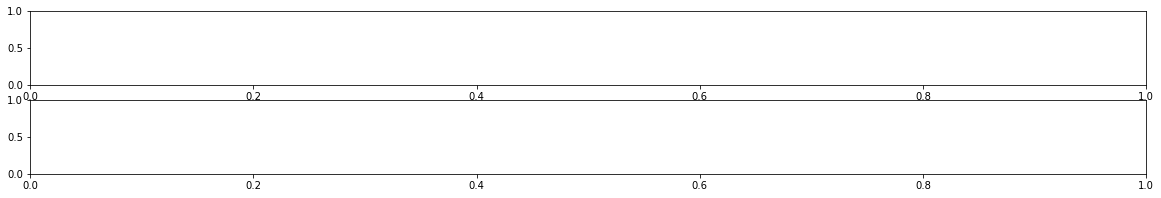

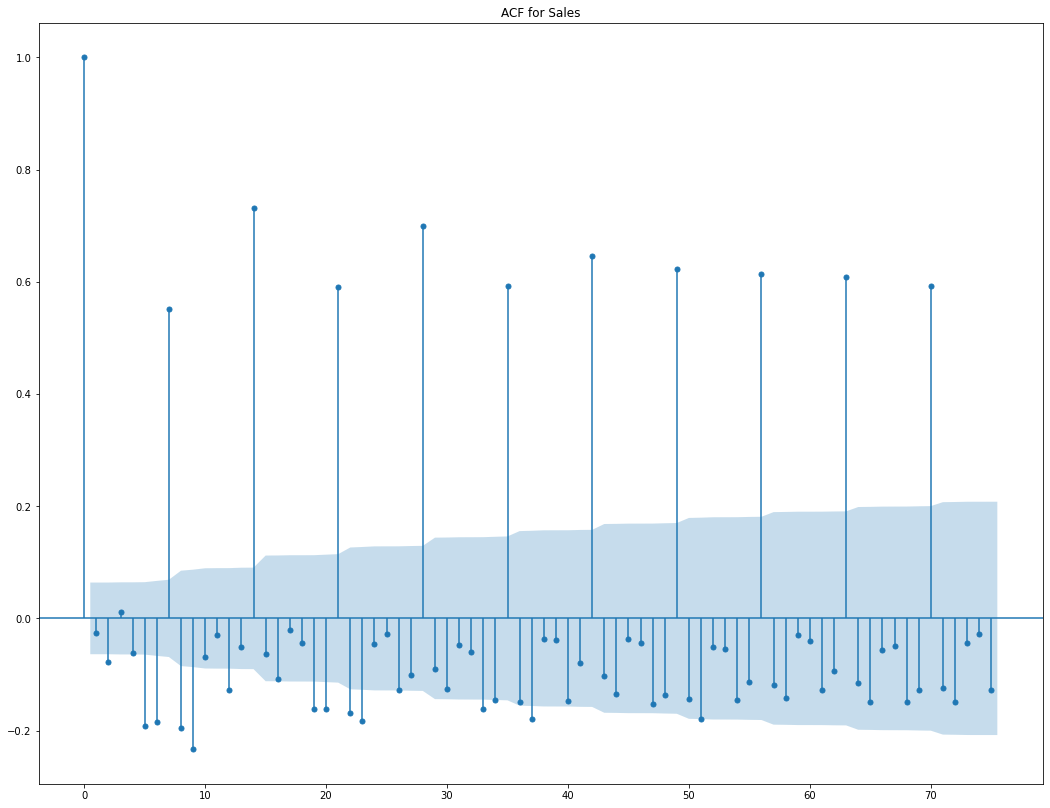

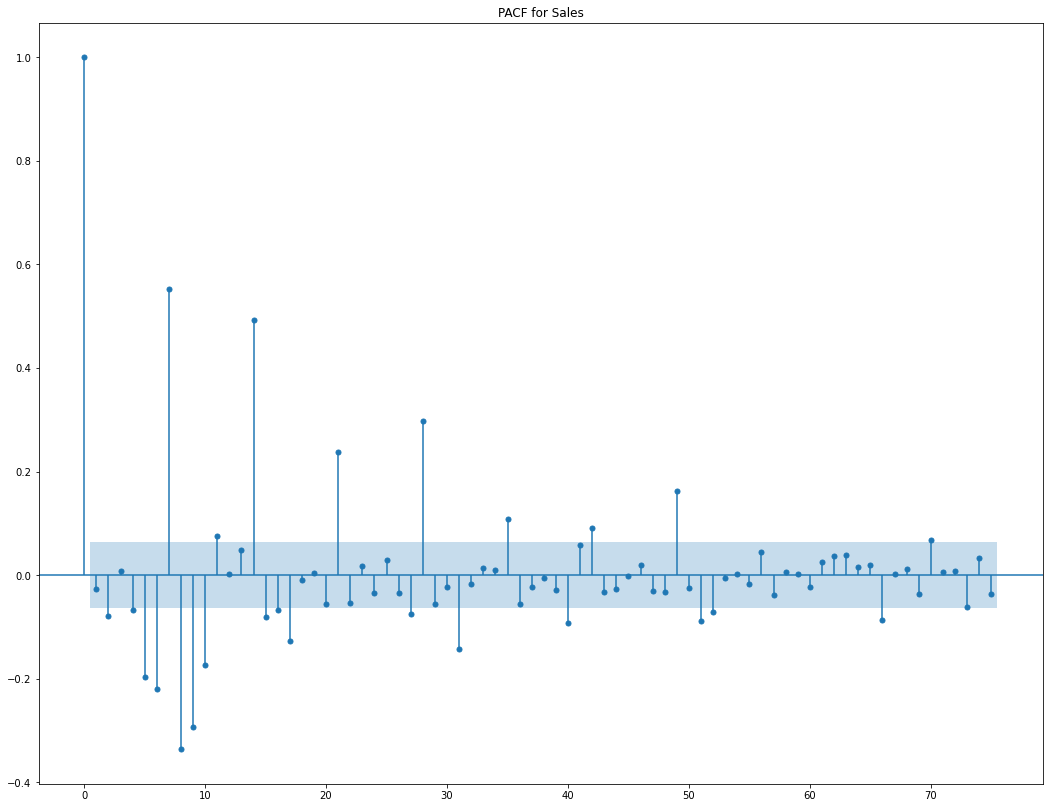

In [46]:
acf_pacf_plot(train_date_group['Sales'],'Sales')

**Observation:**
- For ACF: the co-relation is not dropped below q=0
- For PACF: the highest lag is at when set q=7

## Step 6: Train- Test split

In [47]:
# Setting the first 900 rows as train data
train_len = 900
train_date_group_train = train_date_group.iloc[:train_len,:]
train_date_group_test = train_date_group.iloc[train_len:,:]

In [48]:
# Standardizing the values using min max scaling
scaler = MinMaxScaler()
train_date_group_train[['Sales','Customers','Promo','SchoolHoliday']]=scaler.fit_transform(train_date_group_train[['Sales','Customers','Promo','SchoolHoliday']])
train_date_group_train.head()

,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,
2013-01-01,0.000000,0.000000,0.0,0.999103,1,0,0,0,0,0
2013-01-02,0.441350,0.543373,0.0,1.000000,0,1,0,0,0,0
2013-01-03,0.402577,0.494654,0.0,0.932735,0,0,1,0,0,0
2013-01-04,0.421328,0.508727,0.0,0.932735,0,0,0,1,0,0
2013-01-05,0.377057,0.445579,0.0,0.100448,0,0,0,0,1,0


In [49]:
train_date_group_test[['Sales','Customers','Promo','SchoolHoliday']]=scaler.transform(train_date_group_test[['Sales','Customers','Promo','SchoolHoliday']])
train_date_group_test.head()

,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,
2015-06-20,0.405336,0.453472,0.0,0.0,0,0,0,0,1,0
2015-06-21,0.009824,0.015096,0.0,0.0,0,0,0,0,0,1
2015-06-22,0.415762,0.489576,0.0,0.0,0,0,0,0,0,0
2015-06-23,0.399006,0.475851,0.0,0.0,1,0,0,0,0,0
2015-06-24,0.396755,0.474848,0.0,0.0,0,1,0,0,0,0


## Vector AutoRegressive Model [VAR]

In [50]:
exog = train_date_group_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_date_group_train[['Sales', 'Customers']].astype(float)
var_model = sm.tsa.VAR(endog,exog)
res=var_model.select_order(maxlags=15)
print(res.summary())

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -12.15      -12.05   5.280e-06      -12.11
1       -12.27      -12.15   4.698e-06      -12.22
2       -12.27      -12.12   4.712e-06      -12.21
3       -12.30      -12.14   4.533e-06      -12.24
4       -12.31      -12.12   4.515e-06      -12.24
5       -12.31      -12.10   4.510e-06      -12.23
6       -12.32      -12.09   4.469e-06      -12.23
7       -12.32      -12.07   4.448e-06      -12.23
8       -12.48      -12.20   3.821e-06      -12.37
9       -12.51     -12.21*   3.707e-06      -12.39
10      -12.52      -12.21   3.648e-06      -12.40
11      -12.54      -12.20   3.581e-06      -12.41
12      -12.53      -12.18   3.604e-06      -12.40
13      -12.54      -12.16   3.574e-06      -12.40
14      -12.59      -12.19   3.421e-06     -12.43*
15     -12.59*      -12.17  3.395e-06*      -12.43
-------------------------------

**Observation:** AIC is lowest at lag 11

In [51]:
#Performing model fit with lag value as 11

var_model_final = var_model.fit(11)
var_model_final.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, Apr, 2022
Time:                     23:51:41
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -12.2106
Nobs:                     889.000    HQIC:                  -12.4169
Log likelihood:           3115.22    FPE:                3.56415e-06
AIC:                     -12.5446    Det(Omega_mle):     3.32801e-06
--------------------------------------------------------------------
Results for equation Sales
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.337940         0.057254            5.902           0.000
Promo                 0.169451         0.016244           10.432           0.000
SchoolHoliday        -0.033177         0.012687           -2

## Cointegration Test

In [52]:
# Creating a user defined function for Johanssen test for checking cointegration

In [53]:
def cointegration_test(df, lag): 
    alpha=0.05
    out = coint_johansen(df,-1,lag)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [54]:
train_date_group['Sales']=train_date_group['Sales'].apply(lambda x:round(x))
train_date_group['Customers']=train_date_group['Customers'].apply(lambda x:round(x))

In [55]:
cointegration_test(train_date_group[['Sales','Customers']],10)
rank_result=select_coint_rank(train_date_group[['Sales','Customers']],-1,10)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Sales  ::  127.93    > 12.3212   =>   True
Customers ::  6.57      > 4.1296    =>   True


**Observation:** From the analysis, the rank of Johanssen test as 2 indicate that the time series is not cointegrated

In [56]:
# Getting lag order

lag_ord = var_model_final.k_ar
print(lag_ord) 
forecast_ip = train_date_group_train[['Sales','Customers']].values[-lag_ord:]
forecast_ip

11


array([[0.43595062, 0.50832754],
       [0.41397174, 0.4892133 ],
       [0.41579704, 0.49799996],
       [0.41923316, 0.49742961],
       [0.41303913, 0.45743139],
       [0.0110916 , 0.01718541],
       [0.73892895, 0.69369782],
       [0.61440719, 0.61305964],
       [0.54882338, 0.56709914],
       [0.5213138 , 0.5473912 ],
       [0.53850368, 0.5678536 ]])

## Forecasting using VAR

In [57]:
exog_Test = train_date_group_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
fc = var_model_final.forecast(y=forecast_ip, steps=42,exog_future=exog_Test)
Var_Forecast = pd.DataFrame(fc, index=train_date_group_test.index, columns=['Sales','Customers'])
Var_Forecast

,Sales,Customers
Date,,
2015-06-20,0.441004,0.500055
2015-06-21,0.015879,0.013267
2015-06-22,0.427535,0.508562
2015-06-23,0.414973,0.506646
2015-06-24,0.377980,0.462299
2015-06-25,0.343401,0.426233
2015-06-26,0.434158,0.515352
2015-06-27,0.419477,0.473930
2015-06-28,0.021367,0.018221


In [58]:
#Adding forecasted values

train_date_group_test['Var_Forecasted_Sales']=Var_Forecast.Sales
train_date_group_test['Var_Forecasted_Customers']=Var_Forecast.Customers

In [59]:
# Creating a user defined function for visualizing result

def timeseries_visualization(series,forecasted_series,i,model):
    fig = plt.figure(figsize=(20, 3))
    series.plot(label='Actual')
    forecasted_series.plot(label='Forecasted')
    plt.xlabel('Date')
    plt.ylabel(i)
    plt.legend(loc='best')
    plt.title('{} model For {}'.format(model,i))
    plt.show()

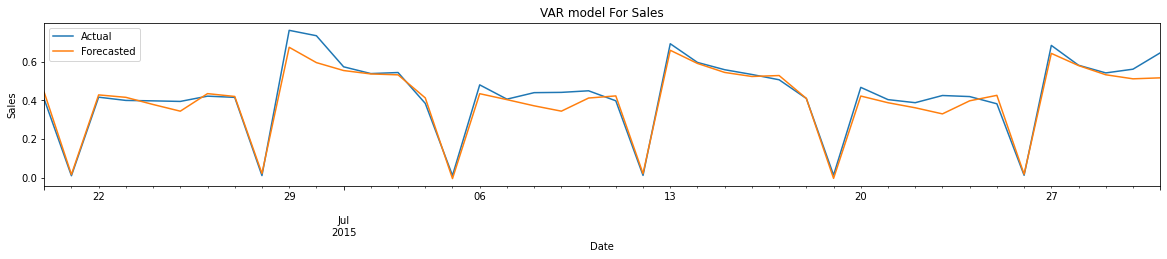

In [60]:
timeseries_visualization(train_date_group_test['Sales'],train_date_group_test['Var_Forecasted_Sales'],'Sales','VAR')

In [61]:
# Storing the results

summary_df=pd.DataFrame(columns=['Store','Model','RMSE_SALES','MAPE_SALES','RMSE_CUSTOMERS','MAPE_CUSTOMERS'])

def summary(s,fs,c,fc,store,model):
    rmse_sales = np.sqrt(mean_squared_error(s, fs)).round(2)
    mape_sales = np.round(np.mean(np.abs(s-fs)/s)*100,2)
    rmse_customers = np.sqrt(mean_squared_error(c, fc)).round(2)
    mape_customers = np.round(np.mean(np.abs(c-fc)/c)*100,2)
    temp=pd.DataFrame({'Store':[store],'Model':[model], 'RMSE_SALES': [rmse_sales],'MAPE_SALES': [mape_sales] , 
                            'RMSE_CUSTOMERS': [rmse_customers],'MAPE_CUSTOMERS': [mape_customers]})
    return temp

In [62]:
d=summary(train_date_group_test['Sales'], train_date_group_test['Var_Forecasted_Sales'],
       train_date_group_test['Customers'], train_date_group_test['Var_Forecasted_Customers'],'All','VAR')
summary_df = pd.concat([summary_df, d])
summary_df.head()

,Store,Model,RMSE_SALES,MAPE_SALES,RMSE_CUSTOMERS,MAPE_CUSTOMERS
0,All,VAR,0.05,19.37,0.03,9.1


## Forecasting using VARMAX

In [63]:
# Building the model
exog = train_date_group_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_date_group_train[['Sales', 'Customers']].astype(float)
varmax_model = sm.tsa.VARMAX(endog, order=(7,0),  exog=exog)
varmax_model_fit = varmax_model.fit(maxiter=1000, disp=False)
print(varmax_model_fit.summary())

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  900
Model:                            VARX(7)   Log Likelihood                3030.093
                              + intercept   AIC                          -5962.186
Date:                    Wed, 06 Apr 2022   BIC                          -5726.869
Time:                            00:01:27   HQIC                         -5872.293
Sample:                        01-01-2013                                         
                             - 06-19-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            1.32, 35.87   Jarque-Bera (JB):     5577.17, 1834.39
Prob(Q):                        0.25, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.61, 1.51   Skew:                     -1.75, -1.49
P

In [64]:
#forecasting on test data

exog_test = train_date_group_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog_test= train_date_group_test[['Sales','Customers']]
varmax_fc = varmax_model_fit.predict(start=train_date_group_test.index.min(),end=train_date_group_test.index.max(),exog=exog_test)
varmax_forecast = pd.DataFrame(varmax_fc, index=train_date_group_test.index, columns=['Sales','Customers'])
varmax_forecast.head()

,Sales,Customers
Date,,
2015-06-20,0.444488,0.503292
2015-06-21,0.012720,0.012184
2015-06-22,0.461409,0.527826
2015-06-23,0.404333,0.497450
2015-06-24,0.366256,0.462665


In [65]:
#Adding forecasted values

train_date_group_test['Varmax_Forecasted_Sales']=varmax_forecast.Sales
train_date_group_test['Varmax_Forecasted_Customers']=varmax_forecast.Customers

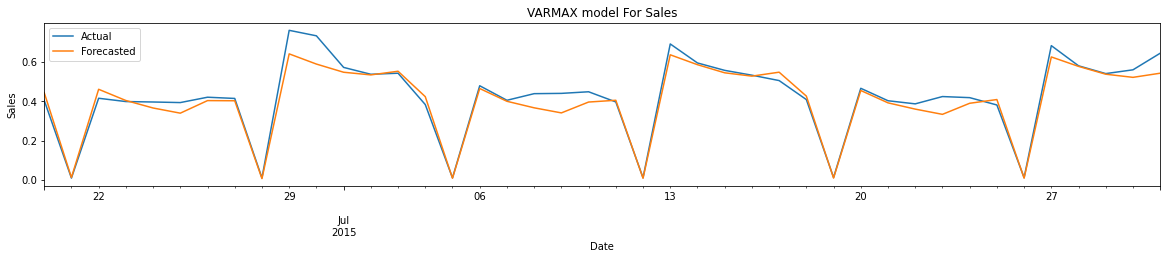

In [66]:
#Plotting the time series analysis

timeseries_visualization(train_date_group_test['Sales'],train_date_group_test['Varmax_Forecasted_Sales'],'Sales','VARMAX')

In [67]:
#Printing results

d=summary(train_date_group_test['Sales'], train_date_group_test['Varmax_Forecasted_Sales'],
       train_date_group_test['Customers'], train_date_group_test['Varmax_Forecasted_Customers'],'All','VARMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head()

,Store,Model,RMSE_SALES,MAPE_SALES,RMSE_CUSTOMERS,MAPE_CUSTOMERS
0,All,VAR,0.05,19.37,0.03,9.10
0,All,VARMAX,0.05,9.81,0.03,7.57
